In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from models.lda import LDAModel
from models.tfidf import TfIdfModel
from objects.dataloader import Dataloader, Issue
from objects.data_utils import *
from objects.tokenizer import Tokenizer

In [2]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [4]:
warnings.filterwarnings("ignore")

In [5]:
plt.style.use("seaborn")
%config InlineBackend.figure_format = 'retina'

# Data Preprocessing

In [7]:
data_path = "./data/pycharm_issues.json"

In [8]:
data = pd.read_json(data_path, lines=True)

In [9]:
data.head()

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]


Так как столбец `Affected versions` представлен в виде списков версий, то `.isna` не поймет, что пустой список – это пропуск значения. Заменим их вручную.

In [10]:
data["Affected versions"] = data["Affected versions"].apply(lambda x: x if x else np.nan)

Определим на каком языке написан `description`.

In [11]:
data["language"] = data["description"].apply(lambda x: detect_language(x))

In [12]:
print_info(data)

Num examples:   22014
Num features:      6

NA ratio stat:
	Column:         idReadable, NA ratio: 0.0
	Column:            created, NA ratio: 0.0
	Column:            summary, NA ratio: 0.0
	Column:        description, NA ratio: 0.00827
	Column:  Affected versions, NA ratio: 0.50045
	Column:           language, NA ratio: 0.01036


Посмотрим какие языки были обнаружены в `description`.

In [13]:
data.language.value_counts()

en       21531
ca          73
tl          57
fr          24
ru          22
no          10
af          10
nl           7
de           7
ro           6
so           6
pt           5
da           5
et           4
it           3
cy           3
es           2
id           2
sv           2
sl           2
bg           2
zh-cn        1
pl           1
sw           1
Name: language, dtype: int64

Оставим только те записи, которые на английском языке. Возможно, мы так уменьшим лишний шум в данных.

In [14]:
data_en = data[data.language.apply(lambda x: x == "en")]

In [15]:
print_info(data_en)

Num examples:   21531
Num features:      6

NA ratio stat:
	Column:         idReadable, NA ratio: 0.0
	Column:            created, NA ratio: 0.0
	Column:            summary, NA ratio: 0.0
	Column:        description, NA ratio: 0.0
	Column:  Affected versions, NA ratio: 0.4964
	Column:           language, NA ratio: 0.0


Для интереса посмотрим на распределение числа `issuses` по релизам. 

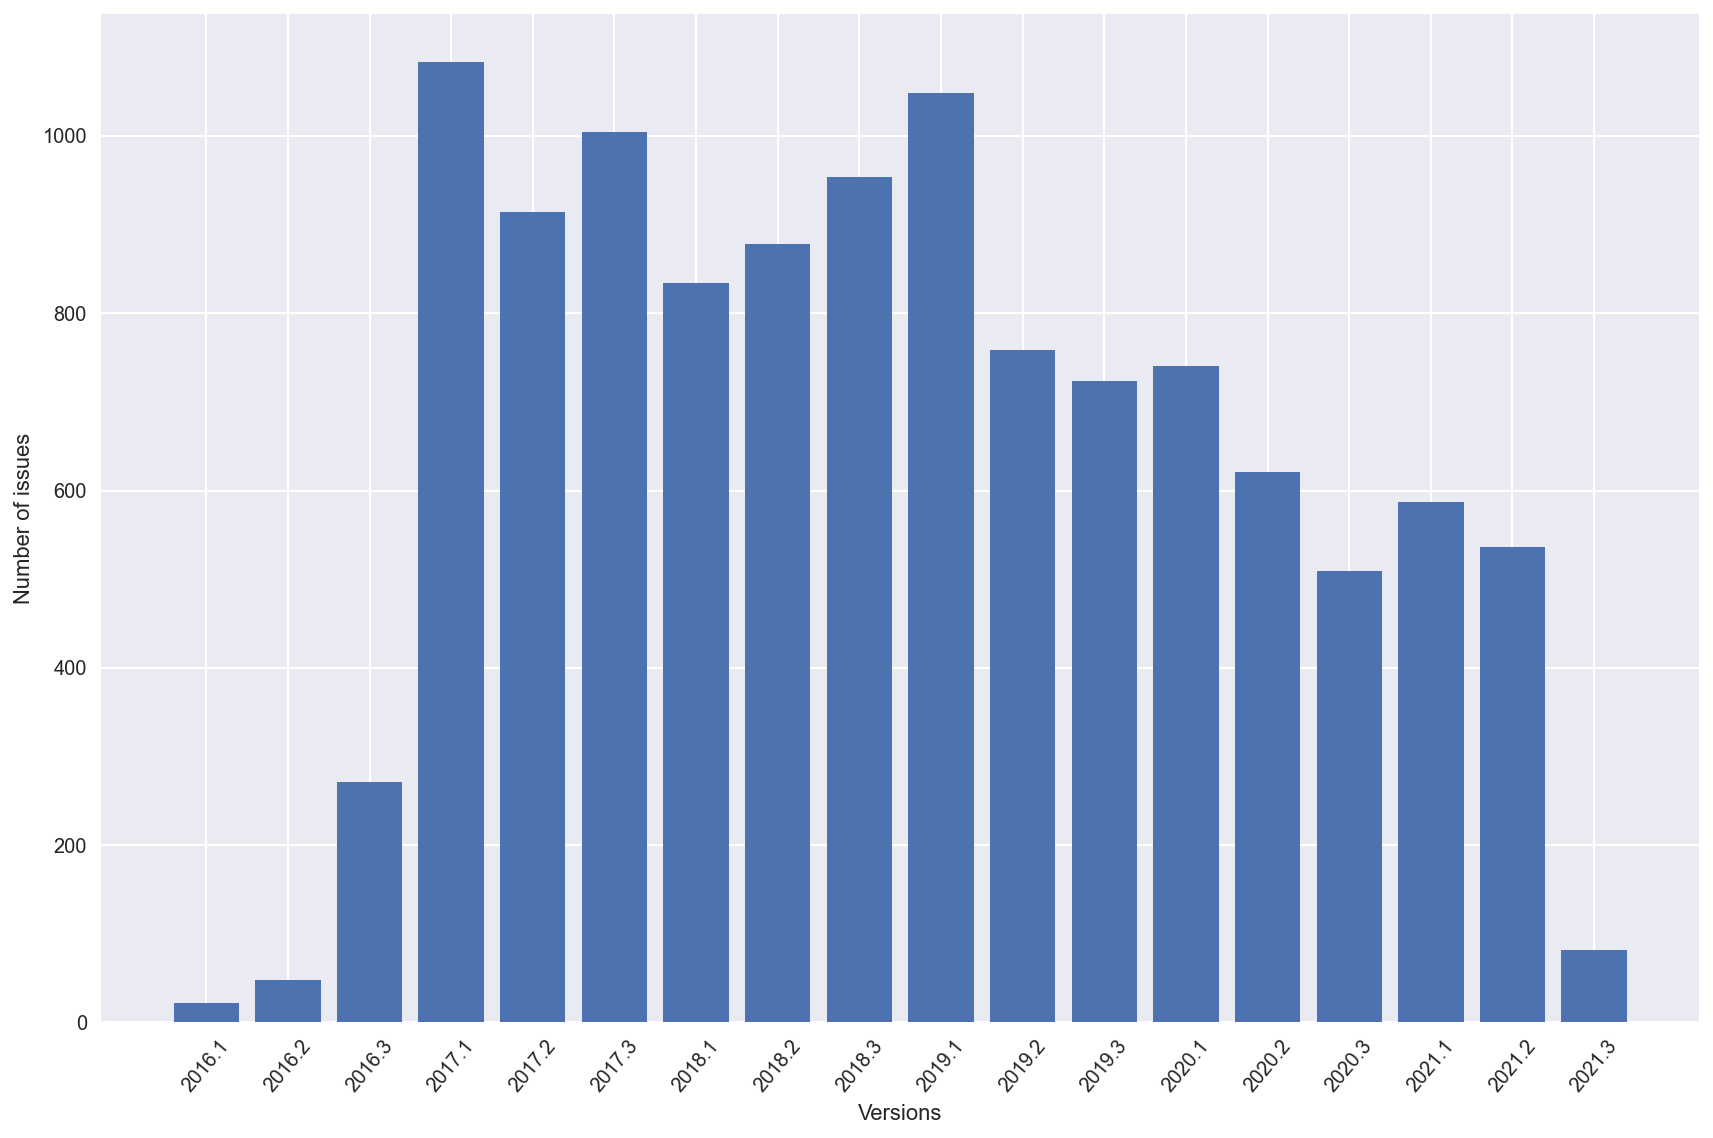

In [16]:
plot_versions_bar(data_en)

Как видно из графика выше, число `issues` в релизе `2020.3` стало меньше, чем в релизе `2020.2`. Может быть что-то стало лучше :).

Оставим только версии `2020.2` и `2020.3`.

In [17]:
versions = ["2020.2", "2020.3"]

In [18]:
dataloader = Dataloader(versions).load_from_df(data_en)

# Models

Рассмотрим несколько примеров моделей (`TfIdfModel` и `LDAModel`).

Начнем с частотного подхода. Просто оценим с помощью `tf-idf` частоту встречаемости слов. 

## TfIdf Model

В качестве корпуса текстов будем использовать `summary`.

In [19]:
tokenizer = Tokenizer()
model = TfIdfModel(tokenizer, 10)

model.handle_dataloader(dataloader)

Версия: 2020.2
Top-10 words:
pycharm, python, type, interpreter, console, code, jupyter, file, project, debugger

Версия: 2020.3
Top-10 words:
pycharm, python, type, package, project, file, import, class, interpreter, code



Теперь посмотрим не на отдельные слова, а на `2-gramms`.

In [20]:
tokenizer = Tokenizer(2)
model = TfIdfModel(tokenizer, 10)

model.handle_dataloader(dataloader)

Версия: 2020.2
Top-10 words:
python console, jupyter notebook, false positive, python interpreter, find usage, unresolved reference, notebook preview, expected type, pycharm pro, return type

Версия: 2020.3
Top-10 words:
false positive, python console, unresolved reference, type annotation, python interpreter, jupyter notebook, code completion, error running, dunder init, wrong type



Попробуем воспользоваться `description`.

In [21]:
tokenizer = Tokenizer()
model = TfIdfModel(tokenizer, 10)

model.handle_dataloader(dataloader, corpus_type="description")

Версия: 2020.2
Top-10 words:
java, com, intellij, impl, openapi, util, basejava, kt, progress, awt

Версия: 2020.3
Top-10 words:
java, com, intellij, impl, openapi, util, desktopjava, awt, basejava, x



Теперь посмотрим не на отдельные слова, а на `2-gramms`.

In [22]:
tokenizer = Tokenizer(2)
model = TfIdfModel(tokenizer, 10)

model.handle_dataloader(dataloader, corpus_type="description")

Версия: 2020.2
Top-10 words:
com intellij, java com, intellij openapi, java java, java basejava, kt com, openapi progress, basejava util, java desktopjava, desktopjava awt

Версия: 2020.3
Top-10 words:
java com, com intellij, java java, intellij openapi, java desktopjava, desktopjava awt, java basejava, com jetbrains, jetbrains python, basejava util



Что-то ничего интересного выделить не получается. Все результаты основаны на частотах. Попробуем применить `LDAModel`.

## LDA Model

In [23]:
tokenizer = Tokenizer()
summaries = [issue.summary for issue in dataloader.issues]

100%|█████████████████████████████████████████| 250/250 [03:41<00:00,  1.13it/s]


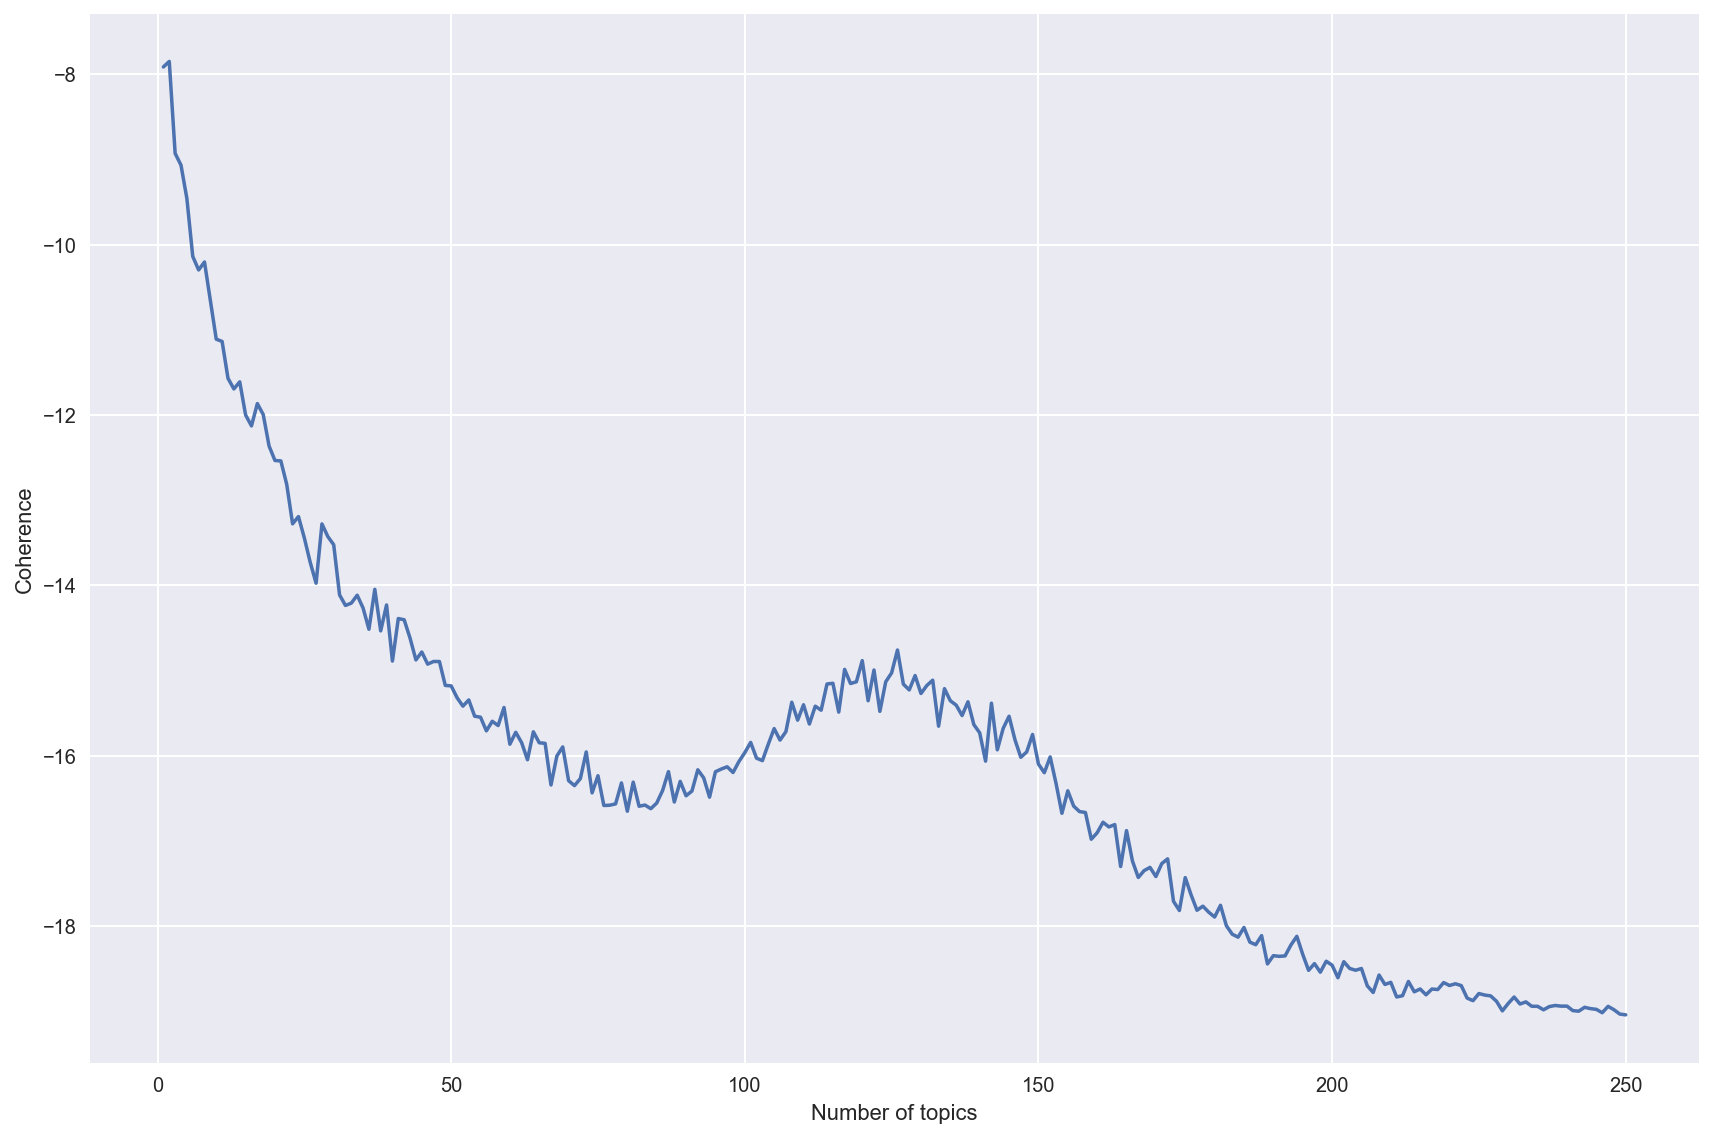

In [24]:
plot_coherence_scores(summaries, list(range(1, 251)))

Возьмем число топиков равным `49` (пик + нравится такое число топиков).

In [33]:
lda = LDAModel(49, tokenizer, summaries)
topics = lda.get_topics()
vis = lda.get_vis()

all_versions = np.array([issue.version for issue in dataloader.issues])
topics = np.array(topics)

In [34]:
topics_by_version = {v: get_top_topics(topics[all_versions == v]) for v in versions}

In [35]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
43    -0.283532 -0.119296       1        1  2.794605
47    -0.235910 -0.049988       2        1  2.777782
36    -0.278858  0.152973       3        1  2.742795
21    -0.100251 -0.151326       4        1  2.738899
48    -0.192977 -0.206268       5        1  2.704323
31     0.296394  0.074121       6        1  2.660788
42     0.041286  0.298387       7        1  2.582922
26     0.274809 -0.128974       8        1  2.565404
33     0.126072 -0.209841       9        1  2.565364
32    -0.275087  0.070550      10        1  2.538268
16    -0.251711 -0.162096      11        1  2.453287
22    -0.014262  0.228112      12        1  2.366273
20     0.094973  0.165644      13        1  2.353433
15    -0.128569  0.271387      14        1  2.220861
44    -0.103065  0.192713      15        1  2.198891
1      0.176395 -0.259850      16        1  2.131853
3      0.283392 -0.001946      17        1  2.131084
27    -0.080926 -0.209712      18        1  2.106526
37    -0.004998 -0.305065      19        1  2.079725
0     -0.172449 -0.094813      20        1  2.074567
11    -0.106084 -0.038975      21        1  2.073187
5     -0.203698  0.165409      22        1  2.067497
28     0.169573 -0.133923      23        1  2.054934
6      0.078175 -0.299435      24        1  2.051697
46     0.114957 -0.087529      25        1  2.020794
18     0.046190 -0.249733      26        1  2.011383
19    -0.305994 -0.001834      27        1  1.978487
41    -0.036498  0.140648      28        1  1.973307
24     0.181576  0.071465      29        1  1.966196
25     0.229238 -0.183209      30        1  1.947594
8     -0.022314  0.022672      31        1  1.933511
12     0.081565  0.007021      32        1  1.887230
14    -0.147757 -0.241089      33        1  1.880378
17    -0.206530  0.238982      34        1  1.867782
34     0.134776  0.257803      35        1  1.831030
39    -0.155327  0.070230      36        1  1.810289
9     -0.210789  0.037625      37        1  1.792078
29     0.201342  0.210995      38        1  1.734238
7     -0.054888  0.300649      39        1  1.701551
30    -0.070667  0.077947      40        1  1.676968
35     0.293498  0.142270      41        1  1.675323
13     0.087953  0.250420      42        1  1.633419
4      0.087177  0.088041      43        1  1.537542
45     0.025729 -0.077424      44        1  1.510351
38    -0.078959 -0.279162      45        1  1.476606
23     0.202925 -0.004795      46        1  1.350491
10     0.219743  0.164789      47        1  1.341596
40     0.015037 -0.144643      48        1  1.300028
2      0.259325 -0.059930      49        1  1.126858, topic_info=         Term        Freq       Total Category  logprob  loglift
98       type  100.000000  100.000000  Default  30.0000  30.0000
52     module   35.000000   35.000000  Default  29.0000  29.0000
27    pycharm  135.000000  135.000000  Default  28.0000  28.0000
167   jupyter   42.000000   42.000000  Default  27.0000  27.0000
14    project   54.000000   54.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
82   notebook    0.790318   28.880310  Topic49  -4.6848   0.8873
706       ssh    0.790316    7.883885  Topic49  -4.6848   2.1856
399     field    0.790315    6.256460  Topic49  -4.6848   2.4168
111      step    0.790315    7.946979  Topic49  -4.6848   2.1776
41       stub    0.790313   10.357546  Topic49  -4.6848   1.9127

[2695 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
956       4  0.415682   ability
956       5  0.207841   ability
956      12  0.207841   ability
956      32  0.207841   ability
669      44  0.655477  abnormal
...     ...       ...       ...
1116     15  0.574468        yn
402       8  0.635491  youtrack
955       9  0.612088      zoom
937       7  0.605121       zsh
1323      8  0.635417     zshcd

[5119 rows x 3 colu

In [36]:
print(f"Топ проблем в 2020.2: {topics_by_version['2020.2'][:5]}")
print(f"Топ проблем в 2020.3: {topics_by_version['2020.3'][:5]}")

Топ проблем в 2020.2: [26 48 42 15 32]
Топ проблем в 2020.3: [47 43 16 36 21]


Посмотрим на слова по каждому топику.

Версия 2020.2:

- 26: (type, global, used, using, property)
- 48: (plot, project, type, name, function)
- 42: (type, pycharm, install, superclass, none)
- 15: (run, docker, interpreter, window, remote)
- 32: (type, code, window, usage, find)

Версия 2020.3:

- 47: (drop, ssh, name, error, debugging)
- 43: (debugger, project, proxy, empty, failed)
- 16: (python, pycharm, venv, line, console)
- 36: (console, inside, cell, instead, sys)
- 21: (python, debugger, size, make, local)

**Вывод**: возможно, в версии 2020.2 были какие-то проблемы с типизацией / построением графиков / докером. А в версии 2020.3 были проблемы с дебагом и удаленным доступом по ssh. Но в любом случае для эксперта эти топики могут сказать больше.

Сделаем все то же самое, но возьмем число топиков равным `125` (еще один локальный максимум).

In [38]:
lda = LDAModel(125, tokenizer, summaries)
topics = lda.get_topics()
vis = lda.get_vis()

all_versions = np.array([issue.version for issue in dataloader.issues])
topics = np.array(topics)

In [39]:
topics_by_version = {v: get_top_topics(topics[all_versions == v]) for v in versions}

In [40]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
69    -0.021617  0.405566       1        1  2.152224
91     0.268383  0.290185       2        1  2.050011
42     0.318865 -0.160018       3        1  1.938002
60     0.104328  0.303154       4        1  1.632869
22     0.312108 -0.042546       5        1  1.585097
...         ...       ...     ...      ...       ...
40    -0.002944 -0.013364     121        1  0.125412
116   -0.002944 -0.013364     122        1  0.125412
43    -0.002944 -0.013364     123        1  0.125412
52    -0.002944 -0.013364     124        1  0.125412
1      0.014429  0.000263     125        1  0.125412

[125 rows x 5 columns], topic_info=             Term       Freq      Total  Category  logprob  loglift
98           type  79.000000  79.000000   Default  30.0000  30.0000
39         python  91.000000  91.000000   Default  29.0000  29.0000
9            file  56.000000  56.000000   Default  28.0000  28.0000
27        pycharm  81.000000  81.000000   Default  27.0000  27.0000
193   interpreter  50.000000  50.000000   Default  26.0000  26.0000
..            ...        ...        ...       ...      ...      ...
14        project   0.003991  44.516934  Topic125  -7.7776  -2.6383
15           root   0.003991   8.758724  Topic125  -7.7776  -1.0124
16   subdirectory   0.003991   3.233526  Topic125  -7.7776  -0.0160
17     virtualenv   0.003991   4.764321  Topic125  -7.7776  -0.4035
19       detected   0.003991   2.736355  Topic125  -7.7776   0.1510

[4907 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
956      11  0.160808   ability
956      28  0.321615   ability
956      49  0.160808   ability
1535     88  0.354774  abstract
849       1  0.289246    accept
...     ...       ...       ...
641      76  0.100530         x
828      21  0.594139    yellow
402      19  0.601221  youtrack
955       9  0.344663      zoom
1323     75  0.372771     zshcd

[2960 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[70, 92, 43, 61, 23, 58, 56, 78, 90, 52, 10, 101, 108, 83, 84, 51, 42, 113, 100, 30, 107, 34, 4, 122, 106, 18, 45, 109, 114, 86, 73, 115, 55, 69, 119, 11, 20, 16, 118, 120, 47, 57, 33, 19, 85, 38, 37, 82, 15, 26, 50, 28, 102, 112, 62, 121, 3, 21, 22, 60, 36, 68, 46, 5, 7, 1, 66, 87, 49, 93, 88, 74, 125, 97, 116, 63, 110, 17, 75, 89, 27, 95, 35, 48, 31, 99, 12, 25, 79, 103, 64, 81, 91, 54, 80, 39, 96, 76, 105, 104, 71, 13, 94, 6, 124, 24, 8, 123, 65, 72, 67, 59, 77, 40, 29, 32, 14, 98, 9, 111, 41, 117, 44, 53, 2])

In [42]:
print(f"Топ проблем в 2020.2: {topics_by_version['2020.2']}")
print(f"Топ проблем в 2020.3: {topics_by_version['2020.3']}")

Топ проблем в 2020.2: [ 42  56  55  19 107  89  77  83  51   9]
Топ проблем в 2020.3: [ 69  29  77  91  60 121  19  37  57  50]


Посмотрим на слова по каждому топику.

Версия 2020.2:

- 42: (notebook, jupyter, builtin, null, display)
- 56: (argument, nondefault, errorneously, redeclaration, follows)
- 55: (source, host, change, code, form)
- 19: (extended, second, pyi, dependency, autoimport)
- 107: (clause, possible, mark, undefined, assigned)

Версия 2020.3:

- 69: (x, type, generic, checker, return)
- 29: (deployment, configuration, interpretet, path, restart)
- 77: (working, unumbased, template, enumerating, djangos)
- 91: (mess, naming, bashprofilezshrc, unnecessarily, available)
- 60: (type, constructor, give, crash, dialog)

**Вывод**: Тут все уже сложнее. И будто бы менее информативно. Возможно стоит рассматривать несколько вариантов с разным числом топиков (ровно как я и сделал, но чуть больше). 